### head

In [1]:
import visualization as viz
import pandas as pd
import numpy as np
import warnings
import operator

from functools import reduce
from tqdm.notebook import tqdm
from test_flow import ABCore as tf

warnings.filterwarnings("ignore")

In [2]:
path = r"C:\Users\repin\Desktop\GitHub\TestLab\development\test-data.csv"
df = pd.read_csv(path)

In [3]:
# добавим данные по месяцу и дате в удобном формате
df['month'] = df['Date'].apply(lambda x: x[:7])
df['dt'] = df['Date'].apply(lambda x: x[:10])

In [4]:
df = df[(df['OrderSource'] == 'web') & (df['Category'] == 'пицца')]

In [5]:
df = df[["dt", "CityName", "rto"]]
df = df[~df["CityName"].isin(["Москва", "Санкт-Петербург"])]

In [6]:
df_pivot = df.pivot_table(
    values="rto",
    columns="dt",
    index="CityName"
)

In [7]:
cols = list(df_pivot.columns)

wrong_cities = []
for i in cols:
    one_row = df_pivot.loc[:, i]
    if one_row.isnull().values.any():
        all_cities = list(one_row[one_row.isnull().values].index)
        for i in all_cities:
            if i not in wrong_cities:
                wrong_cities.append(i)

In [8]:
# убираем города, где есть пропуски в данных
test_wo_denied_ = [i for i in set(df["CityName"]) if i not in wrong_cities]

In [9]:
len(test_wo_denied_)

196

In [10]:
df_clean = df[df["CityName"].isin(test_wo_denied_)]

In [11]:
df_clean.shape

(35476, 3)

In [12]:
len(set(df_clean["dt"])), len(set(df_clean["CityName"]))

(181, 196)

In [13]:
knn_period_days = 56
validation_days = 14
test_days = 14

validation_min_start_date = sorted(list(set(df_clean["dt"].tolist())))[knn_period_days+test_days+1]
validation_max_start_date = sorted(list(set(df_clean["dt"].tolist())))[-validation_days-test_days-1]

validation_min_start_date, validation_max_start_date

('2022-03-13', '2022-06-02')

In [14]:
date_list = pd.date_range(
    start=validation_min_start_date,
    end=validation_max_start_date,
    freq="D",
)
date_list_str = [str(i)[:10] for i in date_list]
len(date_list_str)

82

In [15]:
unit_list = list(set(df_clean["CityName"]))

In [16]:
np.random.choice(date_list_str, 1)[0], list(np.random.choice(unit_list, 3))

('2022-04-06', ['Орск', 'Набережные Челны', 'Магнитогорск'])

### VAL

In [17]:
# default params
test_params = {
    "target_metric": "rto",
    "id_field": "CityName",
    "time_series_field": "dt",
    "number_of_neighbors": 3,
    "test_units": [],
    "alpha": 0.05,
    "cuped_time": 14,
    "start_of_test": "2022-04-07",
    "days_for_knn": 56,
    "days_for_validation": 14,
    "days_for_test": 14,
    "n_iter_bootstrap": 10_000,
}

In [18]:
# зададим параметры для эксперимента
test_params = {
    "target_metric": "rto",
    "id_field": "CityName",
    "time_series_field": "dt",
    "number_of_neighbors": 3,
    "test_units": [],
    "alpha": 0.05,
    "cuped_time": 14,
    "start_of_test": "2022-04-07",
    "days_for_knn": 56,
    "days_for_validation": 14,
    "days_for_test": 35,
    "n_iter_bootstrap": 10_000,
}

In [19]:
df_clean.head(2)

,dt,CityName,rto
7,2022-01-01,Абакан,39132.1742
30,2022-01-01,Азов,9856.7700


In [31]:
save_path = "C:/Users/repin/Desktop/GitHub/TestLab/development/graphs-cuped"
n_tests = 500
n_test_units = 7
skip = 0
saving_result = dict()

for i in tqdm(range(n_tests)):
    
    test_params["test_units"] = list(np.random.choice(unit_list, n_test_units, replace=False))
    test_params["start_of_test"] = np.random.choice(date_list_str, 1, replace=False)[0]
    # instance
    exp = tf(params_dict=test_params)
    exp.create_periods(verbose=False)
    # data
    knn_data_clean = df_clean[
        (df_clean['dt'] >= exp.start_of_knn) & (df_clean['dt'] < exp.start_of_validation)]
    # knn
    knn_pre_exp_clean_scld = exp.get_scaled_data(knn_data_clean)
    knn_vectors, ids_dict = exp.get_vectors(knn_pre_exp_clean_scld)
    all_neighbours_dtw = exp.get_all_neighbors_dtw(knn_vectors)
    all_groups_dtw = exp.get_test_control_groups(all_neighbours_dtw)
    all_units = reduce(operator.iconcat, all_groups_dtw.values(), [])
    
    # validation
    validation_data = df_clean[
        (df_clean['dt'] >= exp.start_of_validation)
        & (df_clean['dt'] < exp.start_of_test)
        & (df_clean["CityName"].isin(all_units))
    ]
    # cuped
    pilot_df_sort, pre_pilot_df_sort = exp.sort_merge_for_cuped(
        knn_data_clean,
        validation_data,
        all_groups_dtw,
        is_validation=True
    )
    cuped_df = exp.calculate_cuped_metric(
        pre_pilot_df_sort,
        pilot_df_sort
    )

    try:
        return_dict = exp.bootstrap(
            cuped_df,
            np.mean,
            0,
            is_cuped=True,
            directory_path=save_path,
            test_id=f"test{i}"
        )
    except AssertionError:
        skip =+ 1
        continue
    return_dict["test_units"] = test_params["test_units"]
    return_dict["control_units"] = all_groups_dtw["control_units"]
    return_dict["start_of_test"] = test_params["start_of_test"]
    saving_result[i] = return_dict

  0%|          | 0/500 [00:00<?, ?it/s]

Theta is: 1.61926837319455
Theta is: 1.114772686793093
Theta is: 1.3114200085659655
Theta is: 1.0930145388573418
Theta is: 0.9989646579154036
Theta is: 1.2179287787459627
Theta is: 1.1187561628414615
Theta is: 1.2856577733001449
Theta is: 1.1244935166738395
Theta is: 0.7790927399348437
Theta is: 1.6972088268331185
Theta is: 1.1680663041616022
Theta is: 1.1491303240710733
Theta is: 1.00941136850195
Theta is: 1.4004758055435504
Theta is: 1.6083229460776725
Theta is: 1.055169334700508
Theta is: 1.1772638770748591
Theta is: 1.1441028871806498
Theta is: 1.1068166252150675
Theta is: 1.0141458562954726
Theta is: 1.0803791294215783
Theta is: 1.1146070242557056
Theta is: 1.1391201173786727
Theta is: 1.0696733693920457
Theta is: 1.3548008955322266
Theta is: 1.5987448322802713
Theta is: 1.0569076475295376
Theta is: 1.7317213349456055
Theta is: 1.2248539753255712
Theta is: 1.2475198122684028
Theta is: 1.1950232312250182
Theta is: 1.0098856758041328
Theta is: 1.6917421083824655
Theta is: 1.29106245

In [30]:
saving_result_1 = saving_result

In [ ]:
#saving_result_2


In [32]:
len(saving_result)

421

In [33]:
np.mean([i["aa_test"] for i in saving_result.values()])

0.023752969121140142

In [34]:
np.mean([i["p_value_aa_boot"] for i in saving_result.values()])

0.5792902612826603

In [35]:
np.min([i["p_value_aa_boot"] for i in saving_result.values()])

0.0022

In [36]:
np.quantile([i["p_value_aa_boot"] for i in saving_result.values()], 0.0)

0.0022

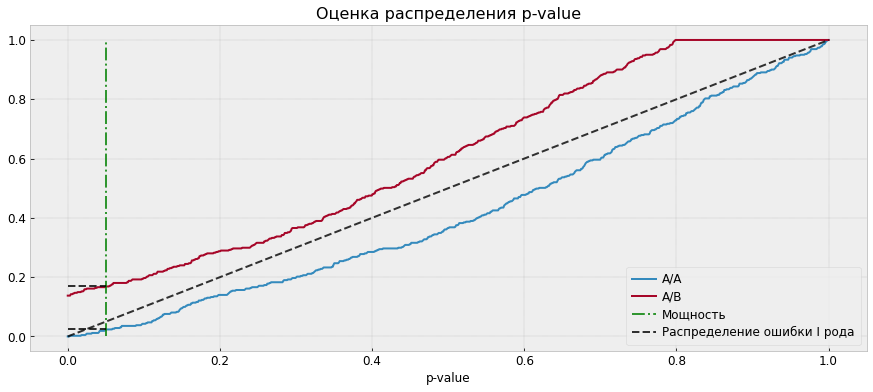

In [37]:
# a/b не смотрим
viz.plot_pvalue_distribution(
    np.array([i["p_value_aa_boot"] for i in saving_result.values()]),
    np.array([i["p_value_ab_boot"] for i in saving_result.values()]) - 0.2
)

In [38]:
import seaborn as sns
from typing import Union, List
import matplotlib.pyplot as plt
def plot_pvalue_ecdf(pvalues: Union[List[float], np.array], title: str = None) -> None:
    """
    Визуализация распределения p-value гистограммой + cdf

    args:
        pvalues - массив значений p-value
        title - заголовок рисунка
    return:
        None
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    if title:
        plt.suptitle(title)
    sns.histplot(pvalues, ax=ax1, bins=50, stat='density')
    ax1.plot([0, 1], [1, 1], 'k--')
    ax1.set_xlabel('p-value')
    ax1.grid(alpha=0.3)
    sns.ecdfplot(pvalues, ax=ax2)
    ax2.set_ylabel('Probability')
    ax2.set_xlabel('p-value')
    ax2.grid(alpha=0.3)

In [31]:
np.array([i["p_value_aa_boot"] for i in saving_result.values()])

array([6.697e-01, 2.038e-01, 1.351e-01, 3.129e-01, 9.141e-01, 3.248e-01,
       9.982e-01, 2.100e-03, 1.408e-01, 1.248e-01, 4.978e-01, 3.000e-04,
       9.515e-01, 6.247e-01, 3.815e-01, 5.634e-01, 7.727e-01, 5.055e-01,
       1.921e-01, 8.987e-01, 4.232e-01, 3.172e-01, 3.893e-01, 7.729e-01,
       2.000e-01, 5.663e-01, 2.808e-01, 3.210e-02, 8.027e-01, 8.852e-01,
       9.706e-01, 8.406e-01, 2.545e-01, 4.911e-01, 4.364e-01, 8.331e-01,
       3.966e-01, 8.870e-01, 7.790e-02, 9.103e-01, 8.116e-01, 7.334e-01,
       8.292e-01, 9.571e-01, 2.458e-01, 7.032e-01, 9.484e-01, 3.227e-01,
       8.509e-01, 8.402e-01, 7.193e-01, 2.994e-01, 7.850e-02, 6.682e-01,
       9.991e-01, 2.281e-01, 6.648e-01, 7.330e-01, 6.557e-01, 4.265e-01,
       5.105e-01, 9.970e-01, 1.331e-01, 9.770e-01, 5.633e-01, 1.322e-01,
       1.926e-01, 4.890e-02, 5.965e-01, 7.230e-02, 7.851e-01, 4.568e-01,
       1.727e-01, 3.243e-01, 3.329e-01, 9.405e-01, 3.047e-01, 6.970e-01,
       8.818e-01, 1.970e-02, 4.646e-01, 9.398e-01, 

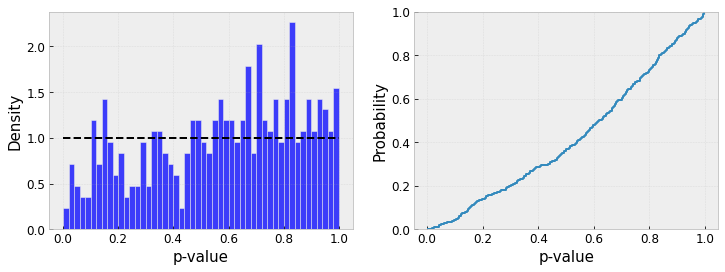

In [39]:
plot_pvalue_ecdf(np.array([i["p_value_aa_boot"] for i in saving_result.values()]))

In [45]:
saving_result[0]

{'aa_test': False,
 'ab_test': False,
 'pe_aa': 2312.805787478357,
 'pe_ab': 2312.805787478357,
 'ci_aa': (-8217.675116899136, 12845.680125709378),
 'ci_ab': (-8212.770646220957, 12973.347681005122),
 'p_value_aa_boot': 0.6697,
 'p_value_ab_boot': 0.6587,
 'theta': 0.7717576926741215,
 'test_units': ['Кемерово',
  'Старый Оскол',
  'Екатеринбург',
  'Рассказовка',
  'Иркутск',
  'Ухта',
  'Курган'],
 'control_units': ['Архангельск',
  'Красное Село',
  'Челябинск',
  'Фрязино',
  'Нижневартовск',
  'Саранск',
  'Щелково'],
 'start_of_test': '2022-04-01'}

In [50]:
low_theta = {}
for key, val in saving_result.items():
    if val["aa_test"] == True:
        low_theta[key] = val

In [52]:
len(low_theta)

19